Author: Elizabeth Luong

Date: 2 April 2025

## Q1


**Gaussian Processes (GPs)**: A Gaussian Process is a special type of stochastic process where any finite collection $\{X_{t_1},...,X_{t_n}\}$ follows a multivariate normal distribution. It is defined by:
- Mean function: $m(t) = \mathbb{E}[X_t]$
- Covariance function *(kernal)*: $k(t,t') = \text{Cov}(X_t, X_{t'})$
GPs are commonly used in non-parametric regression, where we don't specify a fixed model form, GPs "learn" the function shape from data.

**Stochastic Process**: A stochastic process is a collection of random variables indexed by time or space, representing a system evolving under randomness. 
- $\{ X_t : t\in T\}$ where $T$ is an index set (time or space)
- Each $X_t$ is a random variable, and the process capture the joint behaviour across time.

**Variational Inference & ELBO**: When posterior distributions are intractable (as in GPs or mixture models), we approximate them.

**Variational Inference (VI)** does this by:
1. Choosing a simpler family of distributions $q(\theta)$
2. Finding the best $q$ that minimizes the divergence from the true posterior $p(\theta|x)$.
Instead of computing the intractable marginal likelihood directly, we use the **Evidence Lower Bound (ELBO)**: 
$$\text{log}p(x) \geq \mathbb{E}_{q(\theta)} [\text{log} p(x, \theta)] - \mathbb{E}_{q(\theta)}[\text{log} q(\theta)]$$
- The ELBO is optimized instead of $\text{log} p(x)$
- The first term promotes data fit
- The second term penalizes complexity (like regularization)
In Bayesian GPs or mixture models, VI allows scalable inference even when exact methods are computationally infeasible.

## Q2

In [14]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# 1. Generate synthetic dataset
np.random.seed(42)
X = np.linspace(0, 10, 50)
Y = np.sin(X) + np.random.normal(0, 0.3, size=50)

# 2. Define GP model with jitter
with pm.Model() as gp_model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfNormal("η", sigma=1)
    
    # Add jitter via WhiteNoise to stabilize the kernel
    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1e-6)

    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X[:, None])
    σ = pm.HalfNormal("σ", sigma=1)
    y_obs = pm.Normal("y_obs", mu=f, sigma=σ, observed=Y)

    trace = pm.sample(1000, return_inferencedata=False)

# 3. Prediction points
Xnew = np.linspace(0, 10, 200)[:, None]

# 4. Posterior predictions
with gp_model:
    f_pred = gp.conditional("f_pred", Xnew)
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"], return_inferencedata=False)

# 5. Summarize correctly over samples
f_pred_array = pred_samples["f_pred"]  # shape: (1000, 200)
f_pred_mean = np.mean(f_pred_array, axis=0)         # shape: (200,)
f_pred_lower = np.percentile(f_pred_array, 5, axis=0)  # shape: (200,)
f_pred_upper = np.percentile(f_pred_array, 95, axis=0) # shape: (200,)

print("Xnew shape:", Xnew.flatten().shape)
print("f_pred_mean shape:", f_pred_mean.shape)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, η, f_rotated_, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 984 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [f_pred]


Xnew shape: (200,)
f_pred_mean shape: (1000, 200)


In [20]:
# 1. Flatten chains & draws → shape (4000, 200)
f_pred_flat = f_pred_array.reshape(-1, f_pred_array.shape[-1])  # (4 * 1000, 200)

# 2. Compute mean and intervals
f_pred_mean = np.mean(f_pred_flat, axis=0)         # shape: (200,)
f_pred_lower = np.percentile(f_pred_flat, 5, axis=0)
f_pred_upper = np.percentile(f_pred_flat, 95, axis=0)

# Sanity check
print("Flattened f_pred shape:", f_pred_flat.shape)
print("Mean shape:", f_pred_mean.shape)



Flattened f_pred shape: (4000, 200)
Mean shape: (200,)


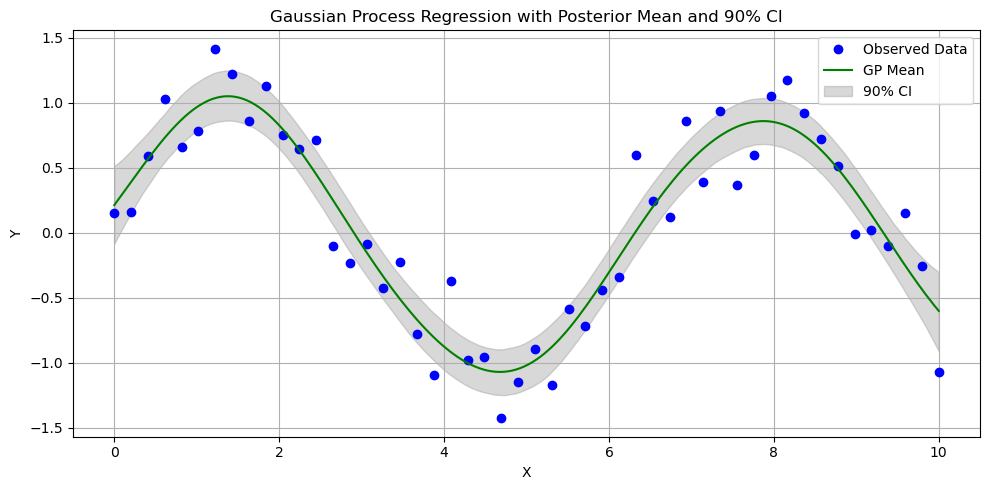

In [21]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(X, Y, "o", label="Observed Data", color="blue")
plt.plot(Xnew.flatten(), f_pred_mean, label="GP Mean", color="green")
plt.fill_between(Xnew.flatten(), f_pred_lower, f_pred_upper, color="gray", alpha=0.3, label="90% CI")
plt.title("Gaussian Process Regression with Posterior Mean and 90% CI")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Q3


In [38]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt

# 1. Generate synthetic data (cosine with noise)
np.random.seed(42)
X = np.linspace(0, 2 * np.pi, 100)[:, None]
Y = np.cos(X).ravel() + np.random.normal(0, 0.1, size=100)

# 2. Define Bayesian Neural Network with VI
with pm.Model() as bnn_model:
    # Step 1: Mutable input
    X_data = pm.MutableData("X", X)

    # Step 2: Bayesian Neural Net layers
    w0 = pm.Normal("w0", 0, 5, shape=(1, 32))
    b0 = pm.Normal("b0", 0, 1, shape=(32,))
    h = pm.math.tanh(pm.math.dot(X_data, w0) + b0)

    # Add another hidden layer:
    w1 = pm.Normal("w1", 0, 1, shape=(32, 16))
    b1 = pm.Normal("b1", 0, 1, shape=(16,))
    h2 = pm.math.tanh(pm.math.dot(h, w1) + b1)

    # Output:
    w_out = pm.Normal("w_out", 0, 1, shape=(16,))
    b_out = pm.Normal("b_out", 0, 1)
    mu = pm.math.dot(h2, w_out) + b_out
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Step 3: Likelihood
    Y_data = pm.MutableData("Y", Y)  # dynamic Y for training only
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y_data)


    # Step 4: Fit with Variational Inference
    approx = pm.fit(40000, method="advi")
    trace_vi = approx.sample(1000)


# 3. Predict
Xnew = np.linspace(0, 2 * np.pi, 200)[:, None]

with bnn_model:
    # Update X and provide dummy Y to match shape
    pm.set_data({"X": Xnew, "Y": np.zeros(Xnew.shape[0])})
    posterior_predictive = pm.sample_posterior_predictive(
    trace_vi,
    var_names=["y_obs"],
    return_inferencedata=False  # This gives it raw NumPy
)

# Get raw posterior predictive samples
y_pred_samples = posterior_predictive["y_obs"]

# Print raw shape
print("Raw y_pred_samples shape:", y_pred_samples.shape)

# Make sure we reduce correctly
if y_pred_samples.ndim == 3:
    # Shape is likely (chains, draws, N) like (4, 250, 200)
    y_pred_samples = y_pred_samples.reshape(-1, y_pred_samples.shape[-1])

# Now summarize
y_mean = np.mean(y_pred_samples, axis=0)       # (200,)
y_lower = np.percentile(y_pred_samples, 5, axis=0)
y_upper = np.percentile(y_pred_samples, 95, axis=0)

# Sanity Check
print("Xnew shape:", Xnew.flatten().shape)
print("y_mean shape:", y_mean.shape)


Finished [100%]: Average Loss = 164.95
Sampling: [y_obs]


Raw y_pred_samples shape: (1, 1000, 200)
Xnew shape: (200,)
y_mean shape: (200,)


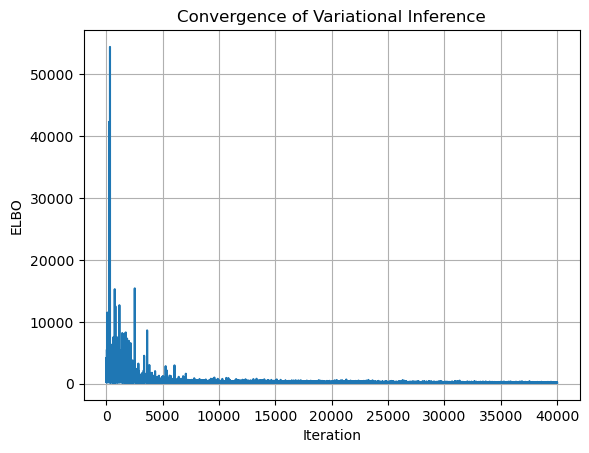

In [39]:
# Monitor learning with loss curve
plt.plot(approx.hist)
plt.ylabel("ELBO")
plt.xlabel("Iteration")
plt.title("Convergence of Variational Inference")
plt.grid(True)
plt.show()


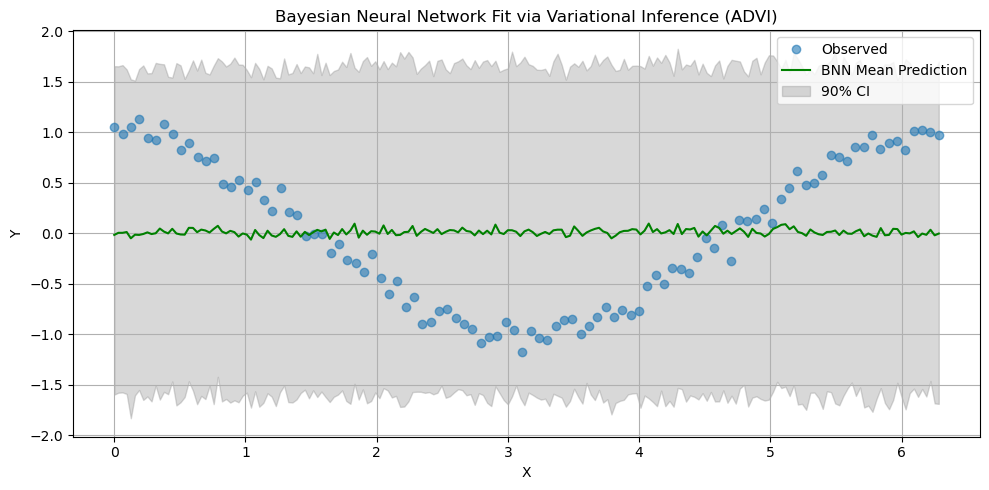

In [40]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(X, Y, "o", label="Observed", alpha=0.6)
plt.plot(Xnew.flatten(), y_mean, label="BNN Mean Prediction", color="green")
plt.fill_between(Xnew.flatten(), y_lower, y_upper, color="gray", alpha=0.3, label="90% CI")
plt.title("Bayesian Neural Network Fit via Variational Inference (ADVI)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
